<a href="https://colab.research.google.com/github/tamucc-gcl/wrkshp_edna_metabarcoding/blob/main/analysis/alpha_diversity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Alpha Diversity Analysis




---
## Initialize Environment

In [2]:
#Set-up Computing Environment - Python

## Mount Google Drive
from google.colab import drive
import os
drive.mount('/content/drive')
os.environ['COLAB'] = 'TRUE'

## Install Linux programs needed
!apt install libfribidi-dev libglpk-dev libharfbuzz-dev pandoc

## Clone GitHub Repo and move into that repo
local_path = '/content/edna_workshop'
repo  = "tamucc-gcl/wrkshp_edna_metabarcoding"
url = f"https://github.com/{repo}.git"
!git clone {url} {local_path}

## Setup R and move to local directory
os.chdir(local_path)
%reload_ext rpy2.ipython

Mounted at /content/drive
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3
  libcmark-gfm-extensions0.29.0.gfm.3 libcmark-gfm0.29.0.gfm.3 libcolamd2
  libcxsparse3 libglpk40 libgmp-dev libgmpxx4ldbl libgraphblas-dev
  libgraphblas6 libgraphite2-dev libharfbuzz-gobject0 libharfbuzz-icu0 libklu1
  libldl2 libmetis5 libmongoose2 librbio2 libsliplu1 libspqr2
  libsuitesparse-dev libsuitesparseconfig5 libumfpack5 pandoc-data
Suggested packages:
  libiodbc2-dev gmp-doc libgmp10-doc libmpfr-dev libgraphite2-utils
  texlive-latex-recommended texlive-xetex texlive-luatex pandoc-citeproc
  texlive-latex-extra context wkhtmltopdf librsvg2-bin groff ghc nodejs php
  python ruby libjs-mathjax libjs-katex citation-style-language-styles
The following NEW packages will be installed:
  libamd2 libbtf1 libcamd2 libccolamd2 libcholmod3
  libcmark-gfm-exte

In [27]:
#Set-up Computing Environment - R
%%R -i local_path
# Point R at your Drive-backed library
drive_lib <- "/content/drive/MyDrive/edna_libraries"
dir.create(drive_lib, recursive = TRUE, showWarnings = FALSE)
.libPaths(c(drive_lib, .libPaths()))

#Install renv if it isn't already
if (!require("renv", lib.loc = drive_lib, quietly = TRUE, warn.conflicts = FALSE)) {
  install.packages("renv", lib = drive_lib,
                   quietly = TRUE, warn.conflicts = FALSE)
}

#Install required libraries into google drive if they aren't already
renv::restore(library = drive_lib,
              lockfile = paste0(local_path, '/renv.lock'),
              prompt = FALSE)

- The library is already synchronized with the lockfile.
[1] "/content/drive/MyDrive/edna_libraries"


In addition: Warning messages:
1: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
2: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
3: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
4: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
5: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory
6: In file(file, "rt") :
  cannot open file '/usr/lib/R/doc/CRAN_mirrors.csv': No such file or directory


---
## User Settings

In [10]:
%%R
min_samples_predator <- 5 #Minimum number of samples of a given predator species to keep it
MIN_NUMBER_PREDATORS_IN <- 20 #How many predators does a genus need to be in to be plotted in the stomach composition plot
inext_predator_subsample <- 5
inext_bootstraps <- 10
tree_bootstraps <- 100
tree_evolutionary_model <- 'all'

---
## Libraries & Data

In [5]:
%%R
library(Biostrings)
library(tidyverse)
library(iNEXT)
library(phangorn)
library(picante)
library(HierDpart)
library(ade4)
library(ggnested)
library(ggtext)
library(patchwork)

source('https://raw.githubusercontent.com/tamucc-gcl/iDIP.phylo/refs/heads/main/iDIP.phylo.R')
source(str_c(here::here(), 'r_functions/fasta2tree.R', sep = '/'))

In [8]:
%%R
storage_dir <- if_else(nzchar(Sys.getenv("COLAB")), drive_lib, here::here())
dir.create(str_c(storage_dir, 'intermediate_files', sep = '/'), showWarnings = FALSE)

predator_gut_contents <- read_csv(str_c(storage_dir,
                                        'intermediate_files/filtered_zotu_counts.csv',
                                        sep = '/'),
                                  show_col_types = FALSE)

zotu_taxonomy <- read_csv(str_c(storage_dir,
                                'intermediate_files/zotu_taxonomy.csv',
                                sep = '/'),
                          show_col_types = FALSE)

predator_taxonomy <- read_rds(str_c(storage_dir,
                                    'intermediate_files/predator_taxonomy.rds',
                                    sep = '/'))


zotu_sequences <- readDNAStringSet(str_c(here::here(),
                                         'output/rainbow_bridge/zotu_sequences.fasta',
                                         sep = '/'))
names(zotu_sequences) <- str_extract(names(zotu_sequences), 'Zotu[0-9]+')
zotu_sequences <- zotu_sequences[names(zotu_sequences) %in% colnames(predator_gut_contents)]

---
## Stomach Contents Composition

In [7]:
%%R
sample_composition <- predator_gut_contents %>%
  pivot_longer(cols = starts_with('Zotu'),
               names_to = 'zotu',
               values_to = 'n_reads') %>%
  filter(n_reads > 0) %>%
  left_join(zotu_taxonomy,
            by = 'zotu') %>%
  mutate(across(where(is.character),
                ~if_else(. == 'LCA_dropped', NA_character_, .))) %>%

  #Skip genus & species for the sake of the legend
  mutate(lowest_level = case_when(#!is.na(species) ~ str_c('s_', species),
                                  !is.na(genus) ~ str_c('g_', genus, ' sp.'),
                                  !is.na(family) ~ str_c('f_', family),
                                  !is.na(order) ~ str_c('o_', order),
                                  !is.na(class) ~ str_c('c_', class),
                                  !is.na(phylum) ~ str_c('p_', phylum),
                                  !is.na(kingdom) ~ str_c('k_', kingdom),
                                  !is.na(domain) ~ str_c('d_', domain),
                                  TRUE ~ 'Unknown'),
         upper_level = case_when(phylum == 'Chordata' & !taxid_rank %in% c('domain', 'kingdom', 'phylum') ~ str_c('c_', class),
                                 TRUE ~ str_c('p_', phylum)),
         .after = species) %>%

  summarise(n_reads = sum(n_reads),
            zotu = unique(zotu) %>% str_c(collapse = '; '),
            .by = c(predator_species_name, upper_level, lowest_level)) %>%

  #Lump together for the sake of the legend/interpretabilitu
  mutate(lowest_level = fct_lump_min(lowest_level, min = MIN_NUMBER_PREDATORS_IN),
         lowest_level = if_else(lowest_level == 'Other',
                                str_c(lowest_level, str_remove(upper_level, '._'), sep = '_'),
                                lowest_level)) %>%
  select(-zotu) %>%
  summarise(n_reads = sum(n_reads),
            .by = where(is.character))

sample_composition %>%
  left_join(predator_taxonomy,
            by = c('predator_species_name' = 'species')) %>%
  ggnested(aes(y = predator_species_name, x = n_reads,
               main_group = upper_level, sub_group = lowest_level),
           legend_labeling = 'sub', legend_title = 'Lowest Taxonomic\nClassification',
           main_keys = TRUE, nested_aes = c("fill"),
           gradient_type = 'both') +
  geom_col(position = 'fill') +
  scale_x_continuous(labels = scales::percent_format()) +
  guides(fill = guide_legend(ncol = 2)) + #ncol = 5
  facet_grid(order ~ ., scales = 'free_y', space = 'free_y', switch = 'y') +
  labs(y = NULL,
       x = 'Relative Number of Reads (%)') +
  theme_classic(base_size = 12) +
  theme(axis.title.x = element_markdown(),
        axis.title.y = element_markdown(),
        panel.background = element_rect(colour = 'black'),
        legend.position = 'right',
        legend.text = element_markdown(size = 4),
        legend.key = element_blank(),
        legend.key.size = unit(0.5, "line"),
        strip.text.y.left = element_text(angle = 0),
        strip.background = element_blank(),
        strip.placement = "outside")

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'predator_gut_contents' not found


RInterpreterError: Failed to parse and evaluate line 'sample_composition <- predator_gut_contents %>%\n  pivot_longer(cols = starts_with(\'Zotu\'),\n               names_to = \'zotu\',\n               values_to = \'n_reads\') %>%\n  filter(n_reads > 0) %>%\n  left_join(zotu_taxonomy,\n            by = \'zotu\') %>%\n  mutate(across(where(is.character), \n                ~if_else(. == \'LCA_dropped\', NA_character_, .))) %>%\n  \n  #Skip genus & species for the sake of the legend\n  mutate(lowest_level = case_when(#!is.na(species) ~ str_c(\'s_\', species),\n                                  !is.na(genus) ~ str_c(\'g_\', genus, \' sp.\'),\n                                  !is.na(family) ~ str_c(\'f_\', family),\n                                  !is.na(order) ~ str_c(\'o_\', order),\n                                  !is.na(class) ~ str_c(\'c_\', class),\n                                  !is.na(phylum) ~ str_c(\'p_\', phylum),\n                                  !is.na(kingdom) ~ str_c(\'k_\', kingdom),\n                                  !is.na(domain) ~ str_c(\'d_\', domain),\n                                  TRUE ~ \'Unknown\'),\n         upper_level = case_when(phylum == \'Chordata\' & !taxid_rank %in% c(\'domain\', \'kingdom\', \'phylum\') ~ str_c(\'c_\', class),\n                                 TRUE ~ str_c(\'p_\', phylum)),\n         .after = species) %>%\n  \n  summarise(n_reads = sum(n_reads),\n            zotu = unique(zotu) %>% str_c(collapse = \'; \'),\n            .by = c(predator_species_name, upper_level, lowest_level)) %>%\n  \n  #Lump together for the sake of the legend/interpretabilitu\n  mutate(lowest_level = fct_lump_min(lowest_level, min = MIN_NUMBER_PREDATORS_IN),\n         lowest_level = if_else(lowest_level == \'Other\', \n                                str_c(lowest_level, str_remove(upper_level, \'._\'), sep = \'_\'),\n                                lowest_level)) %>%\n  select(-zotu) %>%\n  summarise(n_reads = sum(n_reads),\n            .by = where(is.character))\n\nsample_composition %>%\n  left_join(predator_taxonomy,\n            by = c(\'predator_species_name\' = \'species\')) %>%\n  ggnested(aes(y = predator_species_name, x = n_reads, \n               main_group = upper_level, sub_group = lowest_level),\n           legend_labeling = \'sub\', legend_title = \'Lowest Taxonomic\\nClassification\',\n           main_keys = TRUE, nested_aes = c("fill"), \n           gradient_type = \'both\') +\n  geom_col(position = \'fill\') +\n  scale_x_continuous(labels = scales::percent_format()) +\n  guides(fill = guide_legend(ncol = 2)) + #ncol = 5\n  facet_grid(order ~ ., scales = \'free_y\', space = \'free_y\', switch = \'y\') +\n  labs(y = NULL, \n       x = \'Relative Number of Reads (%)\') +\n  theme_classic(base_size = 12) +\n  theme(axis.title.x = element_markdown(),\n        axis.title.y = element_markdown(),\n        panel.background = element_rect(colour = \'black\'),\n        legend.position = \'right\',\n        legend.text = element_markdown(size = 4),\n        legend.key = element_blank(),\n        legend.key.size = unit(0.5, "line"),\n        strip.text.y.left = element_text(angle = 0), \n        strip.background = element_blank(),\n        strip.placement = "outside")\n'.
R error message: "Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : \n  object 'predator_gut_contents' not found"

---
## Using iNEXT to determine alpha diversity


1.   Account for sampling depth
2.   Modern improvements to rarifaction ##TODO - In progress



In [8]:
%%R
endpoint_reads <- predator_gut_contents %>%
  filter(n() >= min_samples_predator,
         .by = predator_species_name) %>%
  pivot_longer(cols = starts_with('Zotu'),
               names_to = 'zotu',
               values_to = 'n_reads') %>%
  summarise(n_reads = sum(n_reads),
            .by = sample_id) %>%
  summarise(mean_reads = mean(n_reads),
            median_reads = median(n_reads)) %>%
  pull(mean_reads) %>%
  floor()

if(!file.exists(str_c(here::here(),
                      'intermediate_files/inext_out.rds',
                      sep = '/'))){
  inext_out <- predator_gut_contents %>%

    filter(n() >= min_samples_predator,
           .by = predator_species_name) %>%

    nest(data = -c(predator_species_name)) %>%
    sample_n(inext_predator_subsample) %>%
    unnest(data) %>%

    select(-pool) %>%
    split(., .$predator_species_name) %>%
    map(~select(.x, -predator_species_name) %>%
          column_to_rownames('sample_id') %>%
          select(where(~sum(.) > 0)) %>%
          t) %>%
    iNEXT(q = c(0),
          datatype = "abundance",
          nboot = inext_bootstraps,
          endpoint = endpoint_reads)
}

if(nzchar(Sys.getenv("COLAB")) &
   file.exists(str_c(here::here(),
                                  'intermediate_files/inext_out.rds',
                                  sep = '/'))){
  inext_out.rds <- read_rds(str_c(here::here(),
                                  'intermediate_files/inext_out.rds',
                                  sep = '/'))
}

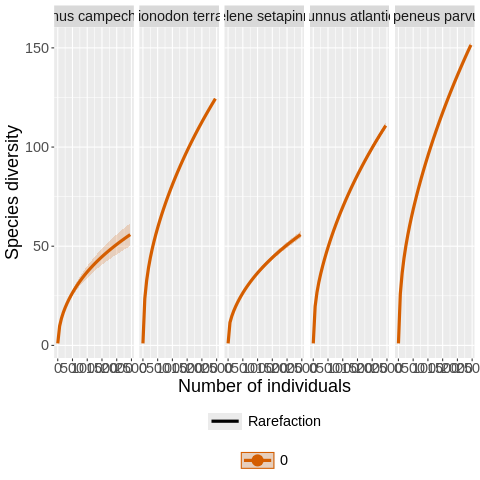

In [9]:
%%R
ggiNEXT(inext_out,
        type = 1,
        se = T,
        facet.var = "Assemblage")

---
## Phylogenetically Informed Alpha Diversity

### Build the Tree

Model        df  logLik   AIC      BIC
          JC 915 -45605.89 93041.77 96469.55 
        JC+I 916 -44480.05 90792.11 94223.63 
     JC+G(4) 916 -39157.45 80146.9 83578.43 
   JC+G(4)+I 917 -39110.1 80054.2 83489.47 
[1] "The best version of the  JC  evolutionary model is: JC+G(4)+I"
Optimized evolutionary model parameters:
 optBf = TRUE 
 optQ = TRUE 
 optInv = TRUE 
 optGamma = TRUE 
optimize edge weights:  -35935.67 --> -34950.21 
optimize edge weights:  -34950.21 --> -34950.17 
optimize topology:  -34950.17 --> -34833.83  NNI moves:  54 
optimize edge weights:  -34833.83 --> -34833.81 
optimize topology:  -34833.81 --> -34833.8  NNI moves:  0 
optimize edge weights:  -34833.8 --> -34833.8 
optimize edge weights:  -34833.8 --> -34833.8 
optimize edge weights:  -39070.3 --> -38295.03 
optimize edge weights:  -38295.03 --> -38294.81 
optimize topology:  -38294.81 --> -38140.37  NNI moves:  59 
optimize edge weights:  -38140.37 --> -38140.32 
optimize topology:  -38140.32 --> -38136

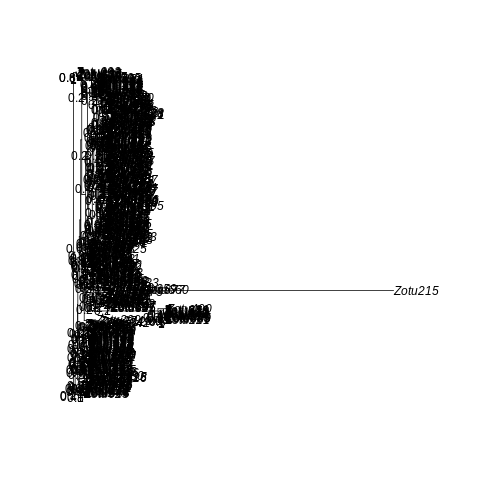

In [11]:
%%R
if(!file.exists(str_c(here::here(),
                      'intermediate_files/zotu_tree.rds',
                      sep = '/'))){
  zotu_tree <- DNAMultipleAlignment(zotu_sequences) %>%
    msa::msaConvert("phangorn::phyDat") %>%
    fasta2tree(n_bootstraps = tree_bootstraps,
               threshold_bootstraps = floor(tree_bootstraps / 2),
               model_ml = tree_evolutionary_model,
               n_cpu = if_else(nzchar(Sys.getenv("COLAB")), 1, parallel::detectCores()))
}

if(nzchar(Sys.getenv("COLAB")) &
   file.exists(str_c(here::here(),
                              'intermediate_files/zotu_tree.rds',
                              sep = '/'))){
  zotu_tree <- read_rds(str_c(here::here(),
                              'intermediate_files/zotu_tree.rds',
                              sep = '/'))
}

In [12]:
%%R
#Plot tree TODO
zotu_tree

$model_ml
model: JC+G(4)+I 
loglikelihood: -39110.1 
unconstrained loglikelihood: -1707.23 
Proportion of invariant sites: 0.1066202 
Model of rate heterogeneity: Discrete gamma model
Number of rate categories: 4 
Shape parameter: 0.6758745 
       Rate Proportion
1 0.0000000  0.1066202
2 0.0772844  0.2233449
3 0.3939211  0.2233449
4 1.0248602  0.2233449
5 2.9813136  0.2233449

Rate matrix:
  a c g t
a 0 1 1 1
c 1 0 1 1
g 1 1 0 1
t 1 1 1 0

Base frequencies:  
   a    c    g    t 
0.25 0.25 0.25 0.25 

$best_model
[1] "JC+G(4)+I"

$model_optim.pml
model: JC+G(4)+I 
loglikelihood: -36760.18 
unconstrained loglikelihood: -1707.23 
Proportion of invariant sites: 0.1085902 
Model of rate heterogeneity: Discrete gamma model
Number of rate categories: 4 
Shape parameter: 0.5891985 
        Rate Proportion
1 0.00000000  0.1085902
2 0.05708725  0.2228524
3 0.34351717  0.2228524
4 0.98238391  0.2228524
5 3.10428579  0.2228524

Rate matrix:
         a        c        g        t
a 0.000000 1.1386

---
### Phylogenetic Diversity

In [13]:
%%R
abundance_phylogeny <- match.phylo.comm(midpoint(zotu_tree$tree),
                                        select(predator_gut_contents,
                                               sample_id, starts_with('Zotu')) %>%
                                          column_to_rownames('sample_id'))

faiths_diversity <- pd(abundance_phylogeny$comm,
                       abundance_phylogeny$phy,
                       include.root = TRUE) %>%
  as_tibble(rownames = 'sample_id')

sample_pd <- predator_gut_contents %>%
  select(-starts_with('Zotu')) %>%
  mutate(phylogenetic_distance = mpd(abundance_phylogeny$comm,
                                     cophenetic.phylo(abundance_phylogeny$phy),
                                     abundance.weighted = FALSE)) %>%
  left_join(faiths_diversity,
            by = 'sample_id')

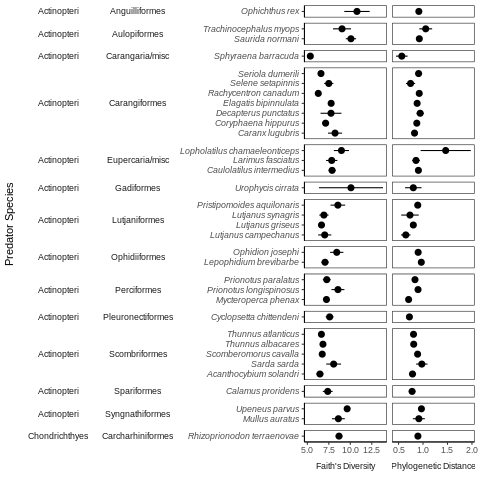

In [15]:
%%R
rename_metrics <- as_labeller(c("PD" = "Faith's Diversity",
                                "phylogenetic_distance" = "Phylogenetic Distance"))
sample_pd %>%
  select(-SR) %>%
  left_join(predator_taxonomy,
            by = c('predator_species_name' = 'species')) %>%
  pivot_longer(cols = c('phylogenetic_distance', 'PD'),
               names_to = 'metric',
               values_to = 'value') %>%
  filter(!is.na(value)) %>%
  ggplot(aes(y = predator_species_name,
             x = value)) +
  stat_summary(fun.data = mean_se) +
  facet_grid(class + order ~ metric,
             scales = 'free',
             space = 'free_y',
             switch = 'both',
             labeller = labeller(metric = rename_metrics)) +
  labs(x = NULL,
       y = 'Predator Species') +
  theme_classic() +
  theme(strip.background = element_blank(),
        strip.text.y.left = element_text(angle = 0),
        strip.placement = 'outside',
        panel.background = element_rect(colour = 'black'),
        axis.text.y = element_text(face = 'italic'))

---
## Hierarchical Alpha Diversity - without Phylogenetic Information

In [16]:
%%R
sampling_hierarchy <- predator_gut_contents %>%
  select(-starts_with('Zotu')) %>%
  mutate(trophic_level = "predator",
         stomach_id = str_extract(sample_id, "\\d+")) %>%
  distinct(trophic_level, predator_species_name,
           stomach_id, pcr_id = sample_id) %>%
  t() %>%
  as.matrix()

idip_abundance <- select(predator_gut_contents,
       sample_id, starts_with('Zotu')) %>%
  column_to_rownames('sample_id') %>%
  t()


IDIP(abun = idip_abundance,
     struc = sampling_hierarchy)

                        [,1]
D_gamma           60.9665333
D_alpha.3         10.9154207
D_alpha.2          2.5586263
D_alpha.1          1.7358800
D_beta.3           5.5853581
D_beta.2           4.2661253
D_beta.1           1.4739650
Proportion.3       0.4833493
Proportion.2       0.4076379
Proportion.1       0.1090128
Differentiation.3  0.6361152
Differentiation.2  0.8183638
Differentiation.1  0.7640737


---
## Hierarchical Alpha Diversity - with Phylogenetic Information

In [17]:
%%R
zotu_tree$tree$node.label <- str_c('node', 1:length(zotu_tree$tree$node.label))

iDIP.phylo(abun = idip_abundance,
           struc = sampling_hierarchy,
           tree = write.tree(zotu_tree$tree))

                 [,1]
Faith's PD 74.7167405
mean_T      0.9691178
PD_gamma    3.7378977
PD_alpha.3  2.2908510
PD_alpha.2  1.3700167
PD_alpha.1  1.1625929
PD_beta.3   1.6316634
PD_beta.2   1.6721337
PD_beta.1   1.1784148
PD_prop.3   0.4192245
PD_prop.2   0.4402033
PD_prop.1   0.1405722
PD_diff.3   0.1810553
PD_diff.2   0.2900114
PD_diff.1   0.3233306


---
## Save Results


In [29]:
%%R
storage_dir <- if_else(nzchar(Sys.getenv("COLAB")), drive_lib, here::here())
dir.create(str_c(storage_dir, 'intermediate_files', sep = '/'), showWarnings = FALSE)

write_rds(inext_out,
          str_c(storage_dir,
                'intermediate_files/inext_out.rds',
                sep = '/'))

write_rds(zotu_tree,
          str_c(storage_dir,
                'intermediate_files/zotu_tree.rds',
                sep = '/'))

write_csv(sample_pd,
          str_c(storage_dir,
                'intermediate_files/phylogenetic_alpha_diversity.csv',
                sep = '/'))

Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : 
  object 'inext_out' not found


RInterpreterError: Failed to parse and evaluate line 'storage_dir <- if_else(nzchar(Sys.getenv("COLAB")), drive_lib, here::here())\ndir.create(str_c(storage_dir, \'intermediate_files\', sep = \'/\'), showWarnings = FALSE)\n\nwrite_rds(inext_out,\n          str_c(storage_dir,\n                \'intermediate_files/inext_out.rds\',\n                sep = \'/\'))\n\nwrite_rds(zotu_tree,\n          str_c(storage_dir,\n                \'intermediate_files/zotu_tree.rds\',\n                sep = \'/\'))\n\nwrite_csv(sample_pd,\n          str_c(storage_dir,\n                \'intermediate_files/phylogenetic_alpha_diversity.csv\',\n                sep = \'/\'))\n'.
R error message: "Error in (function (expr, envir = parent.frame(), enclos = if (is.list(envir) ||  : \n  object 'inext_out' not found"

In [ ]:
#Cleanly unmount Google Drive
drive.flush_and_unmount()